<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

# Functions

In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)


In [3]:
def s2_waveform(event, sensor):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
    
    fontsize = 15
    ev = f'{event}'
    sens = f'sens_{sensor}'

    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as file:

        # Get the group corresponding to the current key
        group = file[ev]


        # Get and print the value corresponding to the current subkey
        signal = group[sens][()]
        signal = pd.DataFrame(signal)
        signal.rename(columns = columns, inplace=True)



        t = signal.time*1e-3 # [us]
        s2 = signal.s2 # [e]
        
        bin_width = 1 # time units ([us])
        
        binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

        events, bins, bars = ax.hist(t, binin, 
                                     weights = s2,
                                     density=False,
                                     histtype='step')
        ax.set_title(f's2 of event {ev} in {sens}', fontsize = font_size);
        ax.set_xlabel('Time [us]', fontsize = font_size);
        ax.set_ylabel('Signal [e]', fontsize = font_size);

        ax.tick_params(axis='both', labelsize = font_size*2/3)
    
            

# Reading the file

In [4]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231215_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231218_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231220_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20231226_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20240109_bb0nu_100ev_s2_signal.h5")
filename = os.path.join(path, "20240113_bb0nu_200ev_s2_signal.h5")


In [5]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/20240113_bb0nu_200ev_s2_signal.h5 (File) ''
Last modif.: '2024-01-13T16:56:12+00:00'
Object Tree: 
/ (RootGroup) ''
/0 (Group) ''
/0/sens_200 (Array(108477, 2)) ''
/0/sens_201 (Array(108477, 2)) ''
/0/sens_202 (Array(108477, 2)) ''
/0/sens_203 (Array(108477, 2)) ''
/0/sens_204 (Array(108477, 2)) ''
/0/sens_205 (Array(108477, 2)) ''
/0/sens_206 (Array(108477, 2)) ''
/0/sens_207 (Array(108477, 2)) ''
/0/sens_208 (Array(108477, 2)) ''
/0/sens_209 (Array(108477, 2)) ''
/0/sens_210 (Array(108477, 2)) ''
/0/sens_211 (Array(108477, 2)) ''
/0/sens_212 (Array(108477, 2)) ''
/0/sens_213 (Array(108477, 2)) ''
/0/sens_214 (Array(108477, 2)) ''
/0/sens_215 (Array(108477, 2)) ''
/0/sens_216 (Array(108477, 2)) ''
/0/sens_217 (Array(108477, 2)) ''
/0/sens_218 (Array(108477, 2)) ''
/0/sens_219 (Array(108477, 2)) ''
/0/sens_220 (Array(108477, 2)) ''
/0/sens_221 (Array(108477, 2)) ''
/0/sens_222 (Array(108477, 2)) ''
/0/sens_223 (Arra

In [6]:
# We read each file, make the histogram and save JUST the max value of that histogram in s2_max_dict

import h5py

# Load the 3D dictionary from the HDF5 file

columns = {0:'time',
           1:'s2'
          }

bin_width = 1000 # [ns] = 1 [us]
s2_max_dict = {}

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as file:
    # Iterate through the top-level keys (groups) in the HDF5 file
    for key in file.keys():
        # Get the group corresponding to the current key
        group = file[key]
        
        # Print the top-level key
        print(f'Top-level key: {key}')
        
        # Iterate through the subkeys (datasets) in the current group
        for subkey in group.keys():
            
            # Check if subkey is already in the dictionary
            if subkey not in s2_max_dict:
                s2_max_dict[subkey] = []
            
            # Get and print the value corresponding to the current subkey
            signal = group[subkey][()]
            signal = pd.DataFrame(signal)
            signal.rename(columns = columns, inplace=True)
            
            t = signal.time
            s2 = signal.s2
            binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)
            
            # Create a histogram
            hist_values, bin_edges = np.histogram(t, bins=binin,
                                                  weights = s2)
            
#             print(f'Subkey: {subkey}, Value: {value}')

            s2_max_dict[subkey].append(hist_values.max()) # peak of s2 signal
    
            
            


Top-level key: 0
Top-level key: 1
Top-level key: 10
Top-level key: 100
Top-level key: 101
Top-level key: 102
Top-level key: 103
Top-level key: 104
Top-level key: 105
Top-level key: 106
Top-level key: 107
Top-level key: 108
Top-level key: 109
Top-level key: 11
Top-level key: 110
Top-level key: 111
Top-level key: 112
Top-level key: 113
Top-level key: 114
Top-level key: 115
Top-level key: 116
Top-level key: 117
Top-level key: 118
Top-level key: 119
Top-level key: 12
Top-level key: 120
Top-level key: 121
Top-level key: 122
Top-level key: 123
Top-level key: 124
Top-level key: 125
Top-level key: 126
Top-level key: 127
Top-level key: 128
Top-level key: 129
Top-level key: 13
Top-level key: 130
Top-level key: 131
Top-level key: 132
Top-level key: 133
Top-level key: 134
Top-level key: 135
Top-level key: 136
Top-level key: 137
Top-level key: 138
Top-level key: 139
Top-level key: 14
Top-level key: 140
Top-level key: 141
Top-level key: 142
Top-level key: 143
Top-level key: 144
Top-level key: 145
To

In [7]:
len(s2_max_dict.values())
s2_max_dict

{'sens_200': [2068.236722463389,
  1812.2974620688728,
  522.5429066152192,
  204.48801325441366,
  956.1498711073291,
  1166.2306981396396,
  894.1909983411788,
  644.4476883793723,
  1117.6005800644361,
  1222.883564824957,
  975.8386482897586,
  545.6402203653556,
  1229.5912139402008,
  221.9046824002803,
  39.174446100371654,
  659.3126868356721,
  489.3910752885922,
  904.6587711782668,
  1309.9780031700075,
  1308.3965858720749,
  1620.895041103562,
  1312.9559308874595,
  747.2461110064069,
  1064.2269909958595,
  259.30611747145974,
  501.28690212655056,
  1028.0998644896986,
  1323.178460544992,
  2169.2345777115115,
  624.8122992525641,
  812.8193379577606,
  808.3133580258645,
  524.1029852824681,
  9.514442675537612,
  1462.7267031060546,
  1435.6223804616711,
  2176.236275355768,
  1403.933334879419,
  766.8967594488017,
  789.7167242499418,
  615.4240181430596,
  724.2357066651193,
  1287.5276514593916,
  1613.1771705908595,
  984.9297876352048,
  1019.1682958760357,
  1

In [8]:
s2_max_dict.keys()

dict_keys(['sens_200', 'sens_201', 'sens_202', 'sens_203', 'sens_204', 'sens_205', 'sens_206', 'sens_207', 'sens_208', 'sens_209', 'sens_210', 'sens_211', 'sens_212', 'sens_213', 'sens_214', 'sens_215', 'sens_216', 'sens_217', 'sens_218', 'sens_219', 'sens_220', 'sens_221', 'sens_222', 'sens_223', 'sens_224', 'sens_225', 'sens_226', 'sens_227', 'sens_228', 'sens_229', 'sens_230', 'sens_231', 'sens_232', 'sens_233', 'sens_234', 'sens_235', 'sens_236', 'sens_237', 'sens_238', 'sens_239', 'sens_240', 'sens_241', 'sens_242', 'sens_243', 'sens_244', 'sens_245', 'sens_246', 'sens_247', 'sens_248', 'sens_249', 'sens_250', 'sens_251', 'sens_252', 'sens_253', 'sens_254', 'sens_255', 'sens_256', 'sens_257', 'sens_258', 'sens_259', 'sens_260', 'sens_261', 'sens_262', 'sens_263', 'sens_264', 'sens_265', 'sens_266', 'sens_267', 'sens_268', 'sens_269', 'sens_270', 'sens_271', 'sens_272', 'sens_273', 'sens_274', 'sens_275', 'sens_276', 'sens_277', 'sens_278', 'sens_279', 'sens_280', 'sens_281', 'sens

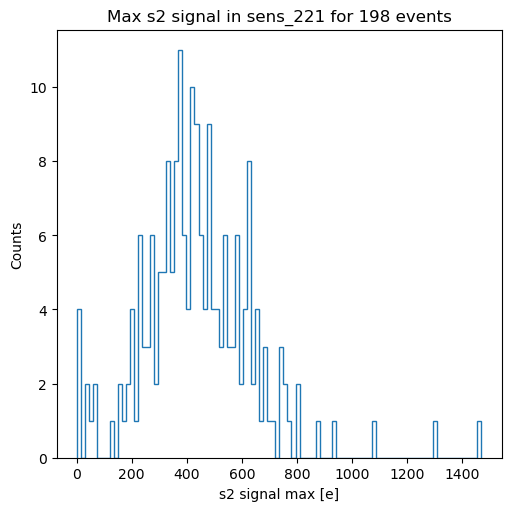

In [9]:
sensor = 'sens_221'

s2 = s2_max_dict[sensor]
s2 = np.array(s2)
n_events = np.size(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 100
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 8.5

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2', 
                             histtype='step')

ax.set_title(f'Max s2 signal in {sensor} for {n_events} events');
ax.set_xlabel('s2 signal max [e]');
ax.set_ylabel('Counts');


In [10]:
subkey

'sens_289'

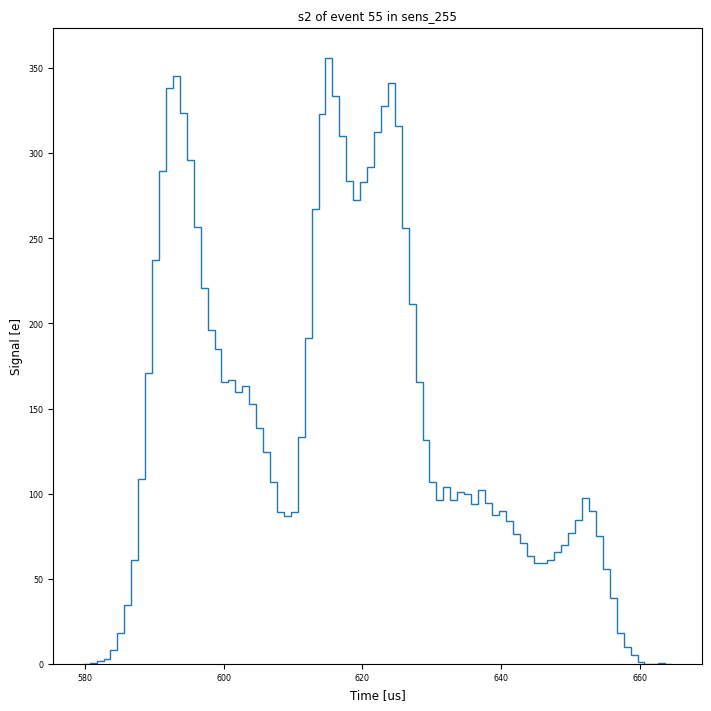

In [11]:
s2_waveform(55, 255)


In [18]:
len(h5py.File(filename, 'r').keys())

198

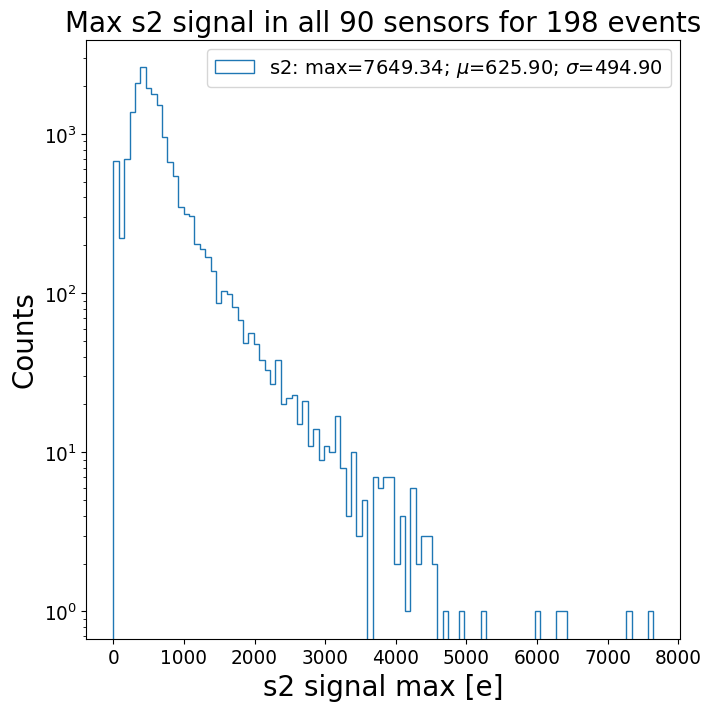

In [13]:
s2 = np.array(list(s2_max_dict.values()))

n_sensors = np.shape(s2)[0]
n_events = np.shape(s2)[1]

s2 = np.concatenate(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7,7), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 100
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 20

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2: max=%.2f; $\mu$=%.2f; $\sigma$=%.2f'%(s2.max(), s2.mean(), s2.std()), 
                             histtype='step')

ax.set_title(f'Max s2 signal in all {n_sensors} sensors for {n_events} events', fontsize = font_size);
ax.set_xlabel('s2 signal max [e]', fontsize = font_size);
ax.set_ylabel('Counts', fontsize = font_size);
ax.set_yscale('log')

ax.legend(fontsize=0.7*font_size, loc='best')

ax.tick_params(axis='both', labelsize = font_size*2/3)

Text(0, 0.5, 'Frequency')

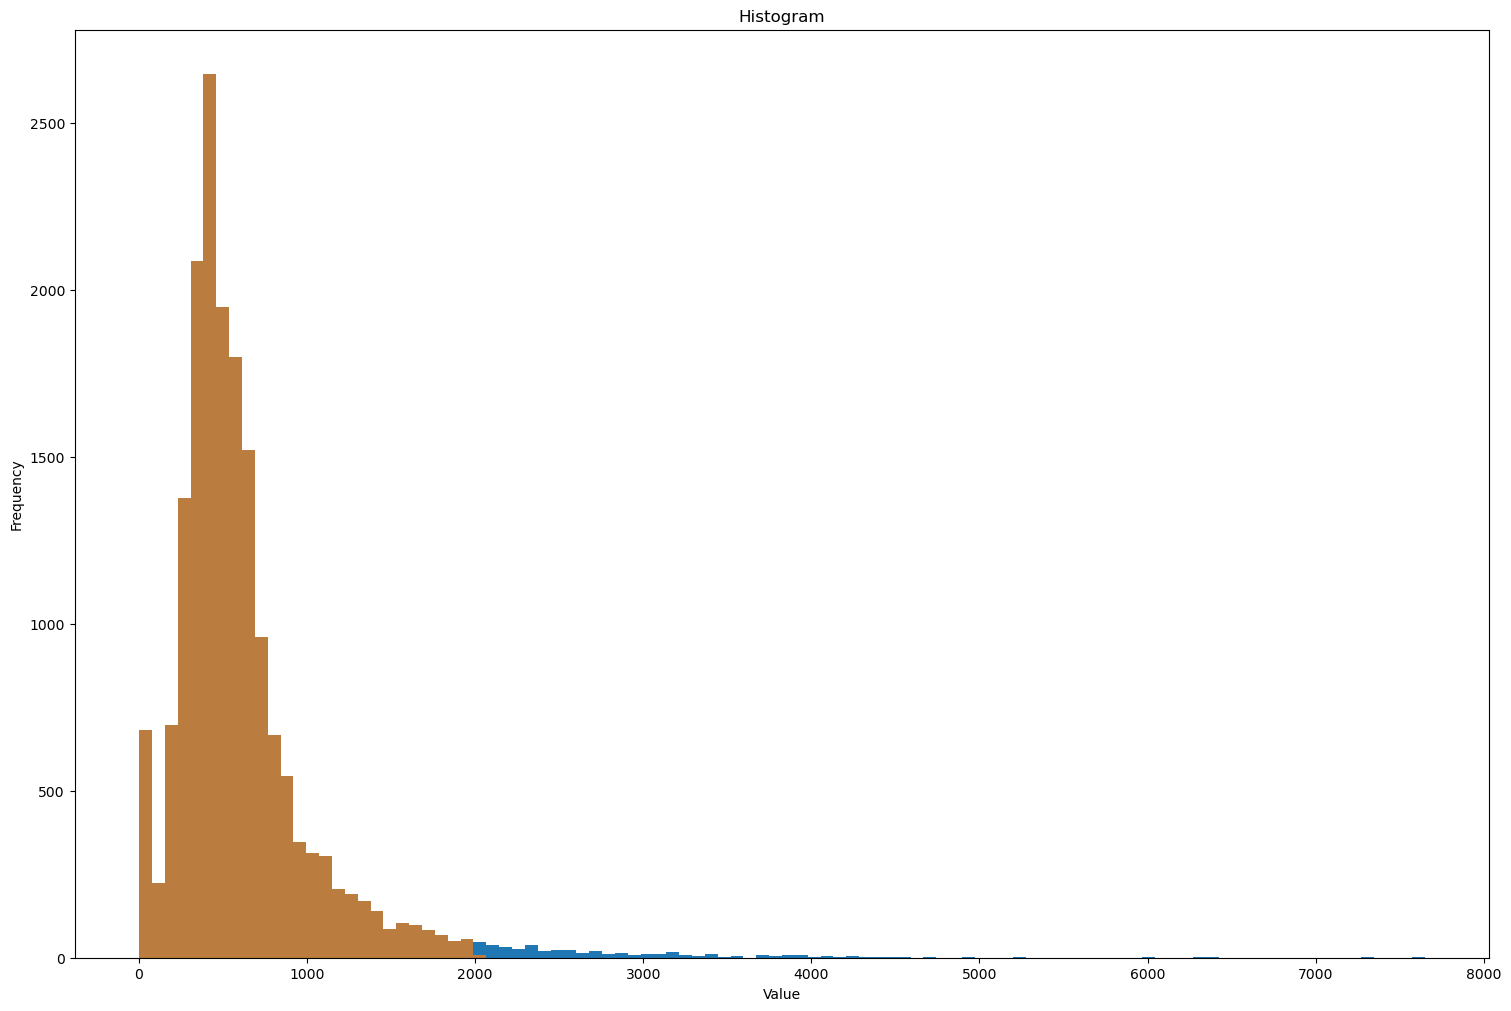

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,10), constrained_layout=True)

s2 = np.array(list(s2_max_dict.values()))
s2 = np.concatenate(s2)

# Create a histogram
events, bin_ref = np.histogram(s2, bins=binin)

# Plot the histogram
ax.hist((bin_ref[1:] + bin_ref[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=1)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

s2 = s2[s2 < 2000]
events, bins = np.histogram(s2, bins=bin_ref)
ax.hist((bins[1:] + bins[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=0.7)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')


In [15]:
s2 = np.array(list(s2_max_dict.values()))
s2 = np.concatenate(s2)

# Create a histogram
events_ref, bin_ref = np.histogram(s2, bins=binin)

cuts = np.arange(s2.max(), s2.min(), -100)
eff_dict = {}

for ii, cut in enumerate(cuts):
    
    s2 = s2[s2 < cut]
    events, bins = np.histogram(s2, bins=bin_ref)
    
    eff = events.sum()*100/events_ref.sum()
    
    eff_dict[cut] = eff
    


In [16]:
# eff_dict

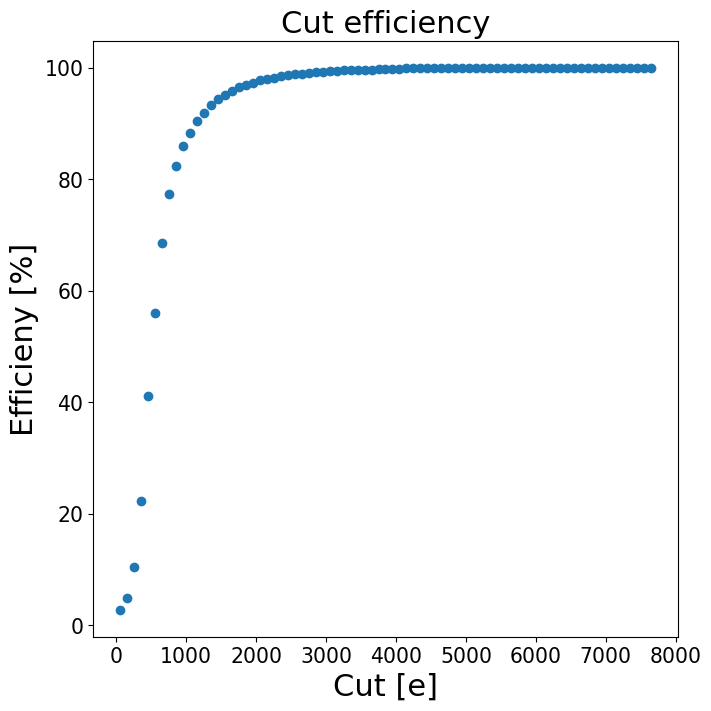

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
font_size = 22

ax.plot(eff_dict.keys(), eff_dict.values(), 'o')
ax.set_title('Cut efficiency', fontsize = font_size)
ax.set_ylabel('Efficieny [%]', fontsize = font_size)
ax.set_xlabel('Cut [e]', fontsize = font_size)

ax.tick_params(axis='both', labelsize = font_size*2/3)
# ax.tick_params(axis='y', labelsize = font_size)
